## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\irvin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.8]
redice_lr_patient = [2,8]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 16s 312us/step - loss: 1.4318 - acc: 0.4991 - val_loss: 1.5514 - val_acc: 0.4541
Epoch 8/10
50000/50000 [==============================] - 16s 316us/step - loss: 1.3996 - acc: 0.5119 - val_loss: 1.5461 - val_acc: 0.4538
Epoch 9/10
50000/50000 [==============================] - 16s 311us/step - loss: 1.3708 - acc: 0.5217 - val_loss: 1.5376 - val_acc: 0.4531
Epoch 10/10
50000/50000 [==============================] - 16s 310us/step - loss: 1.3444 - acc: 0.5321 - val_loss: 1.5030 - val_acc: 0.4694
Numbers of exp: 3, reduce_factor: 0.80, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________


Epoch 3/10
50000/50000 [==============================] - 18s 366us/step - loss: 1.3815 - acc: 0.5151 - val_loss: 1.6266 - val_acc: 0.4339
Epoch 4/10
50000/50000 [==============================] - 18s 369us/step - loss: 1.3129 - acc: 0.5396 - val_loss: 1.5806 - val_acc: 0.4409
Epoch 5/10
50000/50000 [==============================] - 18s 369us/step - loss: 1.2515 - acc: 0.5613 - val_loss: 1.4746 - val_acc: 0.4789
Epoch 6/10
50000/50000 [==============================] - 18s 366us/step - loss: 1.1945 - acc: 0.5843 - val_loss: 1.5472 - val_acc: 0.4514
Epoch 7/10
50000/50000 [==============================] - 18s 369us/step - loss: 1.1457 - acc: 0.6018 - val_loss: 1.4320 - val_acc: 0.4912
Epoch 8/10
50000/50000 [==============================] - 19s 370us/step - loss: 1.1045 - acc: 0.6167 - val_loss: 1.4438 - val_acc: 0.4875
Epoch 9/10
50000/50000 [==============================] - 18s 370us/step - loss: 1.0597 - acc: 0.6344 - val_loss: 1.4939 - val_acc: 0.4802
Epoch 10/10
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 424us/step - loss: 1.8570 - acc: 0.3622 - val_loss: 2.4207 - val_acc: 0.2683
Epoch 2/10
50000/50000 [==============================] - 18s 358us/step - loss: 1.5450 - acc: 0.4523 - val_loss: 2.1844 - val_acc: 0.3165
Epoch 3/10
50000/50000 [==============================] - 18s 356us/step - loss: 1.4197 - acc: 0.4976 - val_loss: 3.4337 - val_acc: 0.2116
Epoch 4/10
50000/50000 [==============================] - 18s 357us/step - loss: 1.3457 - acc: 0.5244 - val_loss: 1.9116 - val_acc: 0.3767
Epoch 5/10
50000/50000 [==============================] - 18s 360us/step - loss: 1.2785 - acc: 0.5485 - val_loss: 2.7586 - val_acc: 0.2441
Epoch 6/10
50000/50000 [==============================] - 18s 357us/step - loss: 1.2276 - acc: 0.5672 - val_loss: 1.8236 - val_acc: 0.3788
Epoch 7/10
50000/50000 [==============================] - 18s 356us/step - loss: 1.1732 - acc: 0.5842 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 463us/step - loss: 1.8210 - acc: 0.3720 - val_loss: 2.0536 - val_acc: 0.3341
Epoch 2/10
50000/50000 [==============================] - 20s 395us/step - loss: 1.5146 - acc: 0.4664 - val_loss: 2.3234 - val_acc: 0.3048
Epoch 3/10
50000/50000 [==============================] - 18s 368us/step - loss: 1.4034 - acc: 0.5059 - val_loss: 2.3731 - val_acc: 0.2929
Epoch 4/10
50000/50000 [==============================] - 18s 359us/step - loss: 1.3284 - acc: 0.5320 - val_loss: 2.3753 - val_acc: 0.2798
Epoch 5/10
50000/50000 [==============================] - 17s 332us/step - loss: 1.2676 - acc: 0.5530 - val_loss: 1.7493 - val_acc: 0.4049
Epoch 6/10
50000/50000 [==============================] - 16s 326us/step - loss: 1.2093 - acc: 0.5750 - val_loss: 1.7674 - val_acc: 0.3792
Epoch 7/10
50000/50000 [==============================] - 17s 330us/step - loss: 1.1611 - acc: 0.5918 - val_loss: 1.

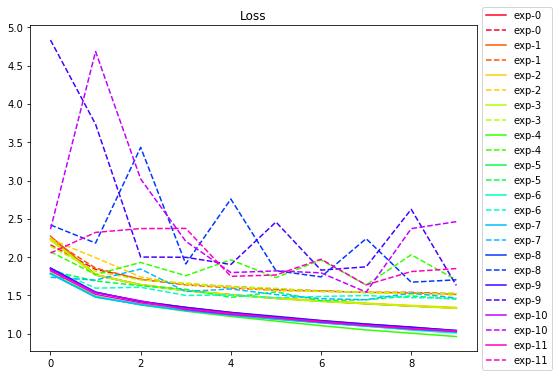

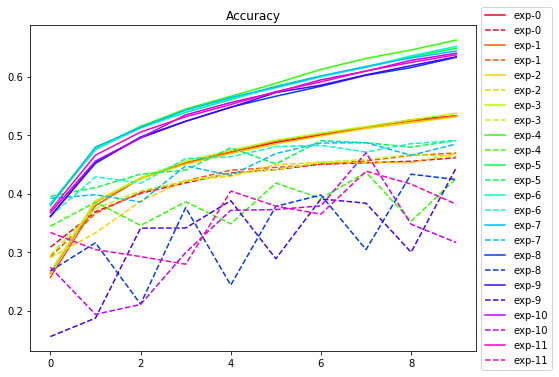

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()